## Importing Modules



In [0]:
import numpy as np
from numpy import array, sin, cos, arctan2, sqrt, pi, asarray, eye, ones, linalg, zeros, transpose, matrix, full,linspace

from numpy.random import seed

from numpy.linalg import multi_dot
from scipy.stats import randint, uniform

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Matrices

In [0]:
def Tz(l):
    return array([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 1, l],
                    [0, 0, 0, 1]])

def Ty(l):
    return array([[1, 0, 0, 0],
                     [0, 1, 0, l],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])
    
def Ry(q):
    return array([[cos(q), 0, sin(q), 0],
                    [0, 1, 0, 0],
                    [-sin(q), 0, cos(q), 0],
                    [0, 0, 0, 1]])
def Rz(q):
    return array([[cos(q), -sin(q), 0, 0],
                     [sin(q), cos(q), 0, 0],
                      [0, 0, 1, 0],
                      [0, 0, 0, 1]])
def dRz(q):
  return array([[-sin(q), -cos(q), 0, 0], [cos(q), -sin(q), 0, 0], [0, 0, 0, 1], [0, 0, 0, 0]])


def dTz():
  return array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 0]])


def dRy():
  return array([[-sin(q), 0, cos(q), 0], [0, 0, 0, 0], [-cos(q), 0, -sin(q), 1], [0, 0, 0, 0]])


def dTy():
  return array([[0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0]])

## Some Usefull functions:

In [0]:
# find forward kinematics of the cylindrical robot with stiffness for joints
def modeling(Q,L,T):
  q1, q2, q3 = Q[0], Q[1], Q[2]
  t1, t2, t3 = T[0], T[1], T[2]
  L1, L2 = L[0], L[1]

  return multi_dot(Rz(-q1), Rz(t1), Tz(L1), Tz(q2), Tz(t2), Ty(L2), Ty(q3), Ty(t3))

# find inverse kinematics for the cylindrical robot
# as a return we return q1, q2, q3

def IK(x,y,z):
  q1 = arctan2(x, y) 
  q2 = z - L1
  q3 = sqrt(x ** 2 + y ** 2) - L2
  return q1, q2, q3

Jacobian for our robot:

In [0]:
def jac(Q, L, T): 
  q1, q2, q3 = Q[0], Q[1], Q[2]
  t1, t2, t3 = T[0], T[1], T[2]
  L1, L2 = L[0], L[1]

  T = multi_dot([Rz(-q1),Rz(t1),Tz(L1),Tz(q2),Tz(t2),Ty(L2),Ty(q3),Ty(t3)])
  T_inv = eye(4)
  T_inv[:3, :3] = T[:3, :3].T

  T1 = multi_dot([Rz(-q1),dRz(t1),Tz(L1),Tz(q2),Tz(t2),Ty(L2),Ty(q3),Ty(t3),T_inv])
  T2 = multi_dot([Rz(-q1),Rz(t1),Tz(L1),Tz(q2),dTz(),Ty(L2),Ty(q3),Ty(t3), T_inv])
  T3 = multi_dot([Rz(-q1),Rz(t1),Tz(L1),Tz(q2),Tz(t2),Ty(L2),Ty(q3),dTy(), T_inv])

  T_ = [T1, T2, T3]
  J = np.array(zeros((6, 3)), dtype=np.float64)

  for i in range(0, 3):
        J[0, i] = T_[i][0, 3]
        J[1, i] = T_[i][1, 3]
        J[2, i] = T_[i][2, 3]
        J[3, i] = (T_[i] * T_inv)[2, 1]
        J[4, i] = (T_[i] * T_inv)[0, 2]
        J[5, i] = (T_[i] * T_inv)[1, 0]

  return linalg.pinv(J).T

## Data assumsions:

In [0]:
L1 = 10
L2 = 10

q2_max = 7
q2_min = 0

q3_max = 8
q3_min = 0

N = 30 #number of experiments


K1 = 1/1000000
K2 = 1/1000000
K3 = 1/5000000

K_REAL = array([K1, K2, K3])
W = array([200, 200, 200, 200, 200, 200])

# set the dimensions clearly
K_REAL.resize(3,1)
W.resize(6,1)


t1, t2, t3 = [0,0,0]

T = [t1,t2,t3]
L = [L1, L2]



# We will need it for matrix K calculations
B = None
C = None

## Data for experiments: (in data_for_experiments variable, array type of triples with(x,y,z)

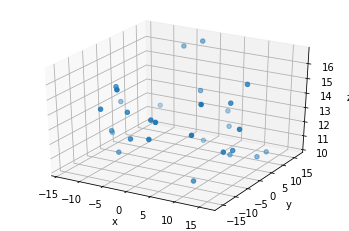

In [48]:
seed(17)

z = uniform.rvs(L1, q2_max, N)
len_after_qz = uniform.rvs(L2, q3_max , N)
qz = uniform.rvs(0, 2*pi, N)
x = cos(qz) * len_after_qz
y = sin(qz) * len_after_qz

data_for_experiments = asarray([x, y, z], dtype=np.float64)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*data_for_experiments)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

## Calibration Part

### K_Theta:

Matrix Q creation. Q = [q1, q2, q3]

In [0]:
Q = []
for x in range(len(data_for_experiments[0])):
    z = data_for_experiments[2][x]
    y = data_for_experiments[1][x]
    x = data_for_experiments[0][x]
    q1,q2,q3 = IK(x, y, z)
    Q.append([q1,q2,q3])

k_theta calculations:

In [50]:
noise_var = 5 * 10**(-4)

for x in range(len(data_for_experiments[0])):
    A = []
    j = jac(Q[x], L, T)

    j1 = j[:,0]
    j1.resize(6,1)

    j2 = j[:,1]
    j2.resize(6,1)

    j3 = j[:,2]
    j3.resize(6,1)
    W.resize(6,1)

    j1 = multi_dot([j1,j1.T, W])
    j2 = multi_dot([j2,j2.T, W])
    j3 = multi_dot([j3,j3.T, W])
    A = np.concatenate((j1,j2,j3), axis = 1)

    temp = np.array(A)
    
    if B is None:
      B = temp.T@temp
    else:
      B = B + temp.T@temp
    noise = np.random.normal(0, noise_var)

    if C is None:
      C = temp.T@(temp@K_REAL)
    else:
      C = C + temp.T@(temp@K_REAL)
    

k = np.linalg.pinv(B)@ C

print("K,real parameters:\n", (1/K_REAL).T)
print("K, estimated: \n", (1/k).T)

K,real parameters:
 [[1000000. 1000000. 5000000.]]
K, estimated: 
 [[ 999999.99999597 1000000.         5000000.        ]]


### Part for Graphs

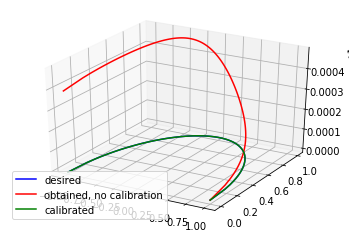

In [54]:
obtained = []
calibrated = []

z = full([30], L1 + q2_max)
angle = linspace(0, 2*pi, 30)
r = L2 + q3_max
x, y = sin(angle) * r, cos(angle) * r

N = 100
x = np.linspace(-1, 1, N)
y = (1 - x**2)**.5
z = np.linspace(0.99999, 1, N)

circle = asarray(([x, y, z, zeros(N), zeros(N), zeros(N)]), dtype=np.float64)
Q_C = []
c_temp = circle[:3]

for x in range(circle.shape[1]):

    z = c_temp[2][x]
    y = c_temp[1][x]
    x = c_temp[0][x]
    q1,q2,q3 = IK(x, y, z)
    Q_C.append([q1,q2,q3])
  
Q_C = np.array(Q_C)

circle = circle.T
for x in range(circle.shape[0]):

    j = jac(Q_C[x], L, T)

    j1 = j[:,0]
    j1.resize(6,1)

    j2 = j[:,1]
    j2.resize(6,1)

    j3 = j[:,2]
    j3.resize(6,1)

    j1 = multi_dot([j1,j1.T, W])
    j2 = multi_dot([j2,j2.T, W])
    j3 = multi_dot([j3,j3.T, W])
    A = np.array(np.concatenate((j1,j2,j3), axis = 1))

    dx = A @ K_REAL
  
    obtained.append((dx.T + circle[x])[0])

    new3 = (circle[x]- dx.T)[0]


    z = new3[2]
    y = new3[1]
    xN = new3[0]

    q1,q2,q3 = IK(xN, y, z)
    tempQ = [q1,q2,q3]

    j = jac(tempQ, L, T)

    j1 = j[:,0]
    j1.resize(6,1)

    j2 = j[:,1]
    j2.resize(6,1)

    j3 = j[:,2]
    j3.resize(6,1)

    j1 = multi_dot([j1,j1.T, W])
    j2 = multi_dot([j2,j2.T, W])
    j3 = multi_dot([j3,j3.T, W])

    tempA = np.array(np.concatenate((j1,j2,j3), axis = 1))

    calibrated.append((tempA@k).T[0] + (circle[x] - dx.T)[0])
obtained = np.vstack(obtained).T
calibrated = np.vstack(calibrated).T
circle = circle.T




fig = plt.figure()
ax = fig.add_subplot(projection='3d')

#the curves for calibrated and actual trajectory is the same
ax.plot(*circle[:3], c="blue", label="desired")
ax.plot(*obtained[:3], c="red", label="obtained, no calibration")
ax.plot(*calibrated[:3], c="green", label="calibrated")

ax.legend()
plt.show()